# Notebook baseline scenario

Basis = notebook Hannah

In [155]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

## Hypothetisch terrein

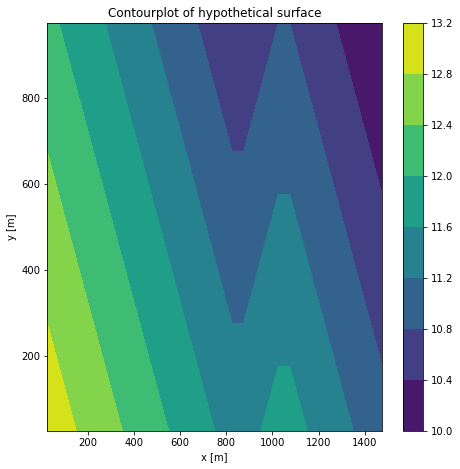

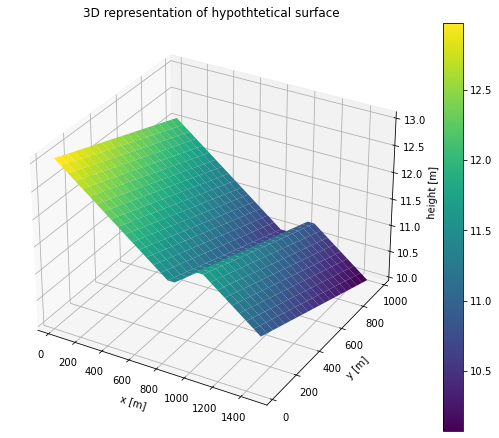

In [156]:
runfile('Grid_hypoth.py')
#convectie: grid[y,x] om zo met contour functies te kunnen werken!

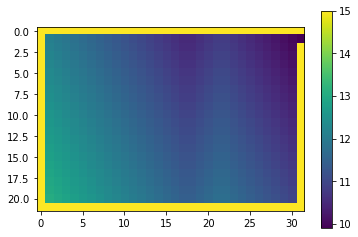

In [157]:
grid_imag = np.zeros((ny+2,nx+2))
grid_imag[1:-1,1:-1] = grid
#boundary conditions
grid_imag[:,0] = 15
grid_imag[:-1,-1] = 15
grid_imag[-2,-1] = grid[-1,-1] - (slopex*deltax) #dus wegdraineren met zelfde gradient
grid_imag[0,:] = 15
grid_imag[-1,:] = 15
plt.imshow(np.flipud(grid_imag))
plt.colorbar()

## Outflux functies en time loop voor variabele $\Delta$t

Aangepaste OutfluxNH functie voor de eerste loop; heeft geen $\Delta$t als input en berekent geen v*.

In [158]:
def OutfluxNH2_init(NH_h, NH_d, Acell, deltax):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    '''
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Fysisch gelimiteerde snelheden (v's) berekenen en maximum opslaan
    v_list = []
    WL_C = watersurface_elv[2] #central cell = derde input
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.01 #Manning's coefficient
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            v_list.append(v)
    if len(v_list)==0: #np.max kan niet toegepast worden op een lege lijst
        vmax_NH = 0
    else:
        vmax_NH = np.max(v_list)
            
    return Fout, vmax_NH

Aangepaste OutfluxNH functie voor alle overige loops; heeft $\Delta$t uit de vorige loop als input en berekent op basis van de met v gecorrigeerde v* een nieuwe $\Delta$t.

In [159]:
def OutfluxNH2(NH_h, NH_d, Acell, deltat, deltax):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    - deltat: berekent in de vorige time loop
    '''
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Flux correction
    vj_list = []
    WL_C = watersurface_elv[2] #central cell = derde input
    z_C = NH_h[2]
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.01 #Manning's coefficient
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
                z_N = NH_h[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
                z_N = NH_h[i+1]
            # Calculate vstar
            dstar = np.max([WL_C,WL_N])-np.max([z_C,z_N])
            if dstar != 0:
                vstar = Fout[i]/(dstar*deltax*deltat)
            elif dstar == 0: #deling door 0 voorkomen
                vstar = 0
            # Calculate v
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            # Flux recalculation if necessary
            if vstar > v:
                vj_list.append(v)
                Fout[i] = v*dstar*deltax*deltat
            else:
                vj_list.append(v) #AANPASSING: ENKEL WERKEN MET DE THEORERTISCHE MAX SNELHEID
    if len(vj_list)==0: #np.max kan niet toegepast worden op een lege lijst
        vjmax_NH = 0
    else:
        vjmax_NH = np.max(vj_list)
    
    return Fout, vjmax_NH

Time loop:

In [160]:
# Parameters definiëren
Acell = deltax*deltay
tend = 500*60
rain = 20/(1000*3600) #regenval in m/s
duration = 3600 
theta = 0.7 #relaxatieparameter (gekalibreerd). Wanneer dit op 1 heeft dit effectief enkel effect op de m

# Initialisatie
deltat = 10*60
depths_imag = np.zeros((ny+2,nx+2))
depths_imag[1:-1,1:-1] = rain*deltat #waterdiepte na 5s regenval aan 20 mm/h
t_list = [] #lijst met tijdstappen
t = deltat
t_list.append(t)
depths_list = [] #lijst met waterdieptes voor alle tijdstap
depths_list.append(depths_imag)


##1## Eerste iteratie in de tijd => functie OutfluxNH2_init
fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
depths_imag = depths_list[-1]
depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
vmax_list = []
for j in np.arange(1,ny+1):
    for i in np.arange(1,nx+1):
        # Hoogtes in neighbourhood
        hneigb1 = grid_imag[j,i+1]
        hneigb2 = grid_imag[j+1,i]
        hneigb3 = grid_imag[j,i]
        hneigb4 = grid_imag[j-1,i]
        hneigb5 = grid_imag[j,i-1]
        NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
        # Waterdieptes in neighbourhood
        dneigb1 = depths_imag[j,i+1]
        dneigb2 = depths_imag[j+1,i]
        dneigb3 = depths_imag[j,i]
        dneigb4 = depths_imag[j-1,i]
        dneigb5 = depths_imag[j,i-1]
        NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
        # Outflow fluxes berekenen
        F,vmax_NH = OutfluxNH2_init(NH_h, NH_d, Acell, deltax)
        F1 = F[0]
        F2 = F[1]
        F4 = F[2]
        F5 = F[3]
        # Toekennen van totale outflow flux centrale cel (!)
        F3 = -F1-F2-F4-F5 
        fluxes_imag[2,j,i] = F3
        # Toekennen van inflow fluxes naburige cellen
        fluxes_imag[3,j,i+1] = F1
        fluxes_imag[4,j+1,i] = F2
        fluxes_imag[0,j-1,i] = F4
        fluxes_imag[1,j,i-1] = F5
        # vmax_NH opslaan in lijst
        vmax_list.append(vmax_NH)
    
# Globale tijdstap updaten
deltat = deltax/np.max(vmax_list[:])
print(deltat)
t = t + deltat
t_list.append(t)
    
depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
#depths_imag_new[-2,-1] = 0 #uitstroomcel legen
# Regenval toevoegen aan waterdiepte
if t < duration: #alleen in het eerste uur
    depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
depths_list.append(depths_imag_new)


##2## Overige iteraties in de tijd => functie OutfluxNH2
while t < tend:
    fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
    depths_imag = depths_list[-1]
    depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
    vjmax_list = []
    for j in np.arange(1,ny+1):
        for i in np.arange(1,nx+1):
            # Hoogtes in neighbourhood
            hneigb1 = grid_imag[j,i+1]
            hneigb2 = grid_imag[j+1,i]
            hneigb3 = grid_imag[j,i]
            hneigb4 = grid_imag[j-1,i]
            hneigb5 = grid_imag[j,i-1]
            NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
            # Waterdieptes in neighbourhood
            dneigb1 = depths_imag[j,i+1]
            dneigb2 = depths_imag[j+1,i]
            dneigb3 = depths_imag[j,i]
            dneigb4 = depths_imag[j-1,i]
            dneigb5 = depths_imag[j,i-1]
            NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
            # Outflow fluxes berekenen
            F,vjmax_NH = OutfluxNH2(NH_h, NH_d, Acell, deltat, deltax)
            F1 = F[0]
            F2 = F[1]
            F4 = F[2]
            F5 = F[3]
            # Toekennen van totale outflow flux centrale cel (!)
            F3 = -F1-F2-F4-F5 
            fluxes_imag[2,j,i] = F3
            # Toekennen van inflow fluxes naburige cellen
            fluxes_imag[3,j,i+1] = F1
            fluxes_imag[4,j+1,i] = F2
            fluxes_imag[0,j-1,i] = F4
            fluxes_imag[1,j,i-1] = F5
            # vmax_NH opslaan in lijst
            vjmax_list.append(vjmax_NH)
      
    # Globale tijdstap updaten
    if not(np.isnan(np.max(vjmax_list))): #CORRIGEER VOOR DE NAN DIE OPTREED
        deltat = deltax/np.max(vjmax_list)
    #print(deltat)
    t = t + deltat
    t_list.append(t)
    if t % 1000 < 10:
        print(t)
            
    depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
    #depths_imag_new[-2,-1] = 0 #uitstroomcel legen. Even niet doen voor vergl
    # Regenval toevoegen aan waterdiepte
    if t < duration: #alleen in het eerste uur
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
    depths_list.append(depths_imag_new)

492.8888079942049


C:\Users\olivi\AppData\Local\Temp/ipykernel_18216/2238314007.py:83: RuntimeWarning: invalid value encountered in double_scalars
  v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
C:\Users\olivi\AppData\Local\Temp/ipykernel_18216/2238314007.py:84: RuntimeWarning: invalid value encountered in sqrt
  v_critical = np.sqrt(g*d)


23002.61603058326
24004.22074086141
27001.10071073674
29002.407339575806


In [161]:
def gif_maken_bis(layers, tijdstappen, fps, naam_file):
    fig, ax = plt.subplots(figsize = (8,8))
    a = layers[0]
    im = plt.imshow(np.flipud(a), interpolation='none', vmin=0, vmax=np.max(depths_list[:]), cmap = 'binary')
    plt.colorbar(im)


    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(np.flipud(layers[i]))
        ax.set_title('time = '+str(tijdstappen[i]/60) + 'min')
    
        return [im]

    anim = animation.FuncAnimation(fig, animate_func, frames = len(layers), interval = 1000 / fps) # in ms)
    anim.save(naam_file+'.gif', writer= 'pillow', fps=fps)# extra_args=['-vcodec', 'libx264'])        
    print("Gif opgeslaan als "+naam_file)

..........................................................................................................Gif opgeslaan als gif_variabeleDeltat_nancorr_nooutflux


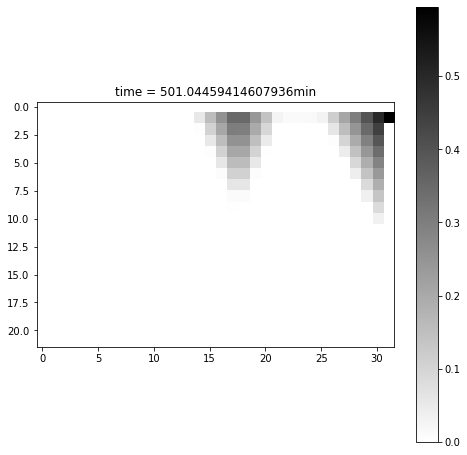

In [162]:
gif_maken_bis(depths_list, t_list, 4, 'gif_variabeleDeltat_nancorr_nooutflux')

Proberen plotten zonder de randen

..........................................................................................................Gif opgeslaan als gif_variabeleDeltat_nancorr_nooutflux_noedge


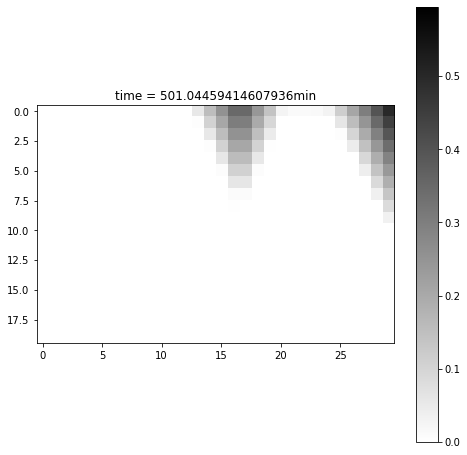

In [163]:
depths_list_bis = [] 
for i in range(len(depths_list)):
    bisframe = depths_list[i][1:-1,1:-1]
    depths_list_bis.append(bisframe)

gif_maken_bis(depths_list_bis, t_list, 4, 'gif_variabeleDeltat_nancorr_nooutflux_noedge')

## Figuur 4 nabootsen

Plot de figuren om de benchmark in de paper zo goed mogelijk na te bootsen. 

In [164]:
times_interest = [40*60,60*60,100*60,200*60]
locs = []
for i in range(len(times_interest)):
    locations = np.where(np.array(t_list) > times_interest[i])
    locs.append(locations[0][0])
locs

[11, 31, 78, 180]

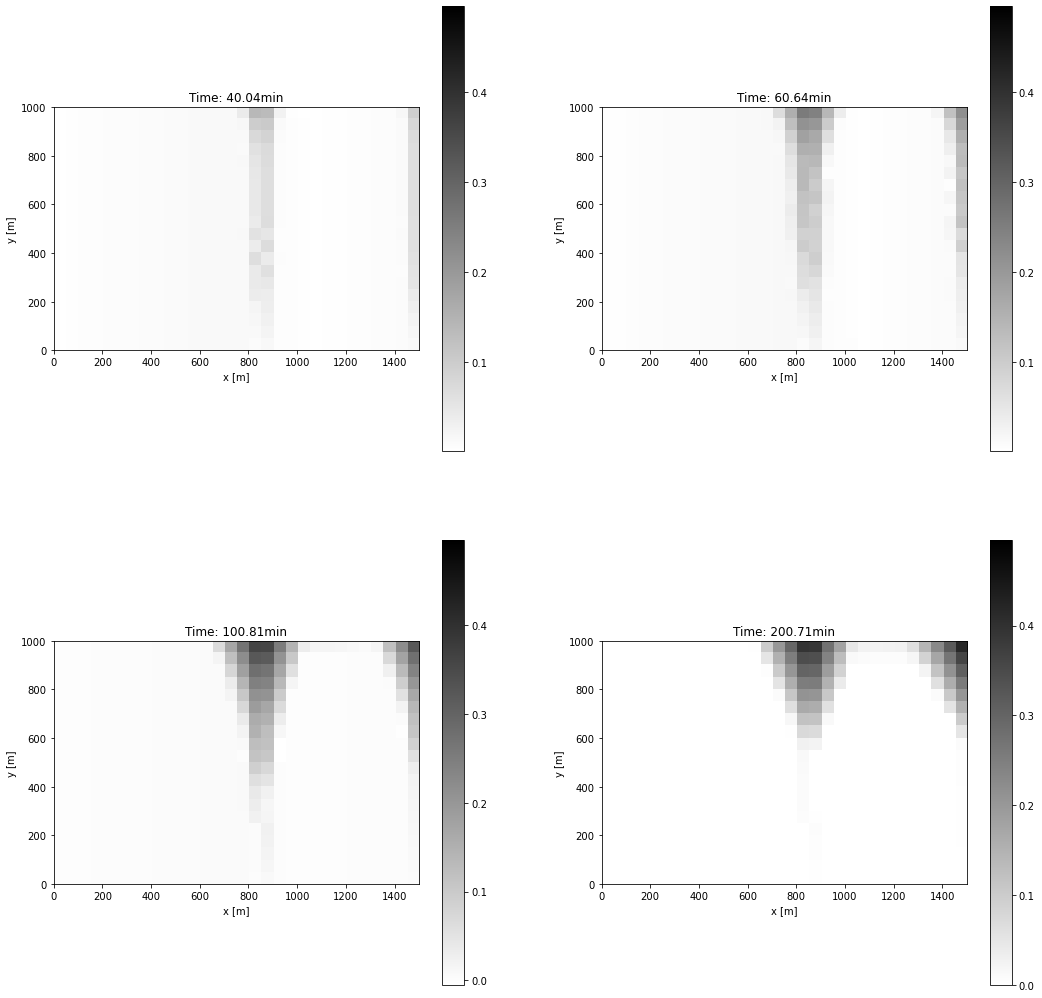

In [165]:
max_depth = np.max(depths_list_bis[:])

plt.figure(figsize = (18,18))
for i in range(len(locs)):
    plt.subplot(2,2,i+1)
    hoogtes = depths_list_bis[locs[i]]
    plt.imshow(np.flipud(hoogtes), vmax = max_depth, cmap = 'binary', extent = [0,1500,0,1000])
    plt.colorbar()
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title('Time: '+ str(np.round(t_list[locs[i]]/60,2)) + 'min')


## Figuur 5 nabootsen

In [166]:
depths_list_bis = [] 
for i in range(len(depths_list)):
    bisframe = depths_list[i][1:-1,1:-1]
    depths_list_bis.append(bisframe)


Text(0.5, 1.0, 'Pond')

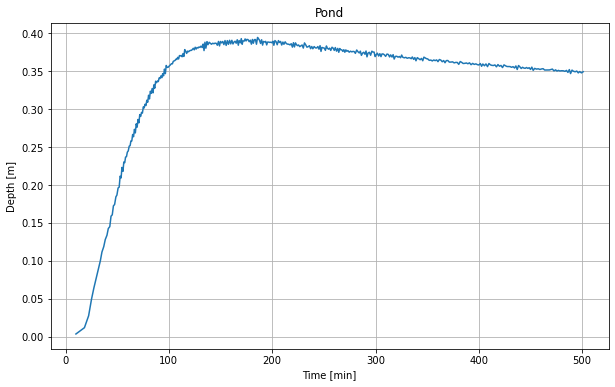

In [167]:
depth_pond_list = []
t_list_min = []
for i in range(len(t_list)):
    depth_pond = depths_list_bis[i][-1,17]
    depth_pond_list.append(depth_pond)
    t_list_min.append(t_list[i]/60)

plt.figure(figsize = (10,6))
plt.grid(b=True)
plt.plot(t_list_min, depth_pond_list)
plt.xlabel('Time [min]')
plt.ylabel('Depth [m]')
plt.title('Pond')

Text(0.5, 1.0, 'CrestL')

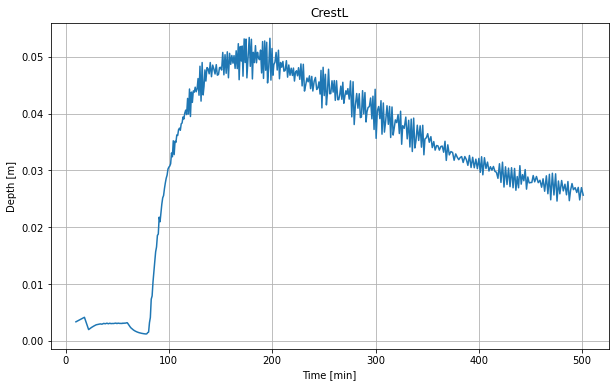

In [168]:
depth_crestL_list = []
t_list_min = []
for i in range(len(t_list)):
    depth_crestL = depths_list_bis[i][-1,20]
    depth_crestL_list.append(depth_crestL)
    t_list_min.append(t_list[i]/60)

plt.figure(figsize = (10,6))
plt.grid(b=True)
plt.plot(t_list_min, depth_crestL_list)
plt.xlabel('Time [min]')
plt.ylabel('Depth [m]')
plt.title('CrestL')

Text(0.5, 1.0, 'CrestR')

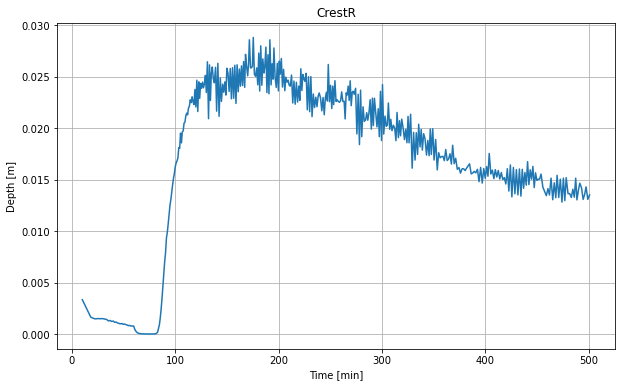

In [169]:
depth_crestR_list = []
t_list_min = []
for i in range(len(t_list)):
    depth_crestR = depths_list_bis[i][-1,21]
    depth_crestR_list.append(depth_crestR)
    t_list_min.append(t_list[i]/60)

plt.figure(figsize = (10,6))
plt.grid(b=True)
plt.plot(t_list_min, depth_crestR_list)
plt.xlabel('Time [min]')
plt.ylabel('Depth [m]')
plt.title('CrestR')

Resultaten komen zeker in de buurt, maar ons model lijkt trager te verlopen. Indiceert dat tijdstapidee een struikeblok blijft voor de correcte implementatie. 